In [1]:
#__Import libraries and script needed__
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# System and Path Libraries for Module Import
import os
import sys


# Set up the Project Path
# Add this line to your ~/.bashrc or ~/.zshrc: export REALTIMEID_PATH='/absolute/path/to/project'
project_path = os.environ.get('REALTIMEID_PATH')
if project_path and project_path not in sys.path:
    sys.path.append(project_path)
    print("Project path successfully added.")
else:
    print("Warning: 'REALTIMEID_PATH' environment variable is not set.")

# Import Custom Modules for Green's Function Kernel Analysis
from src.discr_error.discr_error import DiscrError  # Class for discretization error analysis and related functions
from src.dlr_kernel.dlr_kernel import DlrKernel  # Interpolative decomposition and utilities (e.g., effective coupling computation)
from src.utils import common_funcs as cf  # Utilities for grid generation, spectral density computations, etc.
from src.data_interpolation.data_interpolation import DataInterp
from src.utils.plot_utils import plot_data
from src.store_kernel.store_kernel import Hdf5Kernel

Project path successfully added.


In [2]:
#_____Set Parameters______

DEFAULT_PHI = np.pi / 4
params = {
    "m": None,  # to be updated for each computation
    "n": None,  # to be updated for each computation
    "N_max": None,  # not specified as we will directly pass the time grids "times"
    "delta_t": 0.1,  #this step that we will use below to set the time grids
    "beta": np.inf,  # inverse temperature
    "upper_cutoff": np.inf,  # frequency cutoff for continous integrations
    "h": None,  # to be updated for each computation
    "phi": DEFAULT_PHI,
}  # either "N_max" and "delta_t" OR "times" needs to be specified to define the time grid. If all is specified, the argument "times" is used as time grid


h_vals = np.log(
    np.arange(2., 1.0, -0.0125)
)  # array with values of h which should be explored.


nbr_iterations = len(h_vals)



In [3]:
#_______Evaluate the error between the dicrete-frequency approximation and the continous-frequency integral_____
N_maxs = np.concatenate((np.arange(20,30,5),np.arange(1100,100,1000)))
nbr_N_maxs = len(N_maxs)
delta_t = 0.1

# create empty array in which to store DiscrError objects
discr_errors = np.empty(shape=(len(N_maxs),nbr_iterations), dtype=object)


for tau, N_max in enumerate(N_maxs):
    print(f'Evaluating time t={params["delta_t"] * N_max}')
    cf.update_parameters(params, {"N_max": N_max})

    times = cf.set_time_grid(N_max=params["N_max"], delta_t= params["delta_t"])

    #compute continous integral
    cont_integral = np.array([cf.cont_integral(t, params["beta"], params["upper_cutoff"])for t in times])  
    

    for i, h in enumerate(h_vals):
        cf.update_parameters(params, {"h": h})

        discr_error = DiscrError(
            **params, cont_integral_init=cont_integral
        )  # DiscrError object which holds the error w.r.t. to the continous results, and all associated parameters.

        discr_error.optimize()  # optimize values for m and 

        #Exit the loop it error is below machine precision, otherwise, append to array
        if discr_error.eps < 1.e-14:
            break
        else:
            discr_errors[tau, i] = discr_error


Evaluating time t=2.0


/Users/julianthoenniss/Documents/PhD/code/channel_IF/RealTimeID/src/utils/common_funcs.py:258: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  right_segment_cont_real, _ = integrate.quad(


Evaluating time t=2.5


In [4]:
#Evaluate the Real-time Kernel and its interpolative decomposition (ID) for various values of N_max and beta.

D = np.empty((nbr_N_maxs, nbr_iterations), dtype = object)  # Pre-allocate the array

for tau in range(nbr_N_maxs):
    for i in range(nbr_iterations):
        D[tau, i] = DlrKernel(discr_errors[tau, i])

In [5]:
name_template = '../data/beta={}_delta_t={}.h5'
filename = name_template.format(params["beta"], params["delta_t"])

#store data related to kernel object 
hdf5_kernel = Hdf5Kernel(filename=filename)
hdf5_kernel.store_kernel_data(D)

In [6]:
errors_rw, m_vals_rw, n_vals_rw, h_vals_rw, ID_ranks_rw = hdf5_kernel.read_to_array()

/Users/julianthoenniss/Documents/PhD/code/channel_IF/RealTimeID/src/store_kernel/store_kernel.py:130: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ID_ranks[idx] = data["ID_rank"]


In [7]:
#_______Extract the data that we want to visualize below________
errors, m_vals, n_vals, h_vals, ID_ranks = cf.create_numpy_arrays_from_kernel(D)

print(np.allclose(errors, errors_rw))
print(np.allclose(m_vals, m_vals_rw))
print(np.allclose(n_vals, n_vals_rw))
print(np.allclose(h_vals, h_vals_rw))
print(np.allclose(ID_ranks, ID_ranks_rw))



nbr_modes_total = m_vals + n_vals

True
True
True
True
True


In [8]:
#_______Set global plot parameters____________
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica", "font.size": 8})
cmaps = [plt.get_cmap("Blues"), plt.get_cmap("Reds")]
colors_blue = cmaps[0](np.linspace(0.35, 0.9, len(N_maxs)))
colors_orange = cmaps[1](np.linspace(0.35, 0.9, len(N_maxs)))

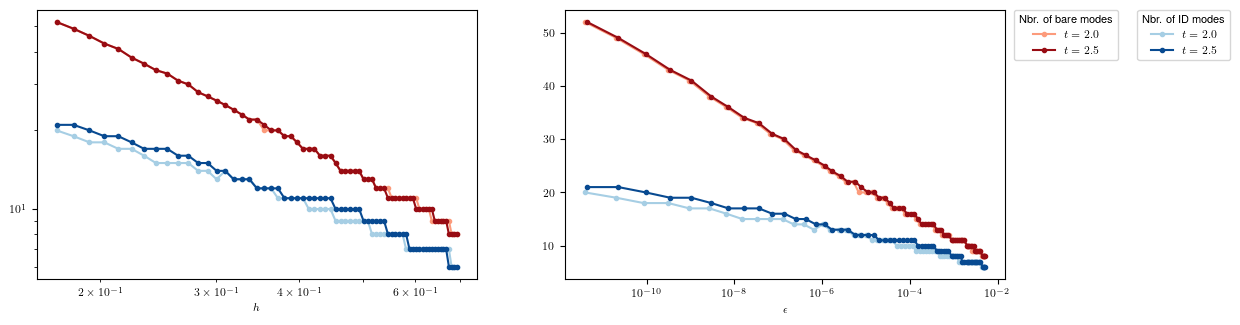

In [9]:
#_____Plot the number of modes versus the error and the discretization parameter h____
fig, axs = plt.subplots(1, 2, figsize=(12.5, 3.5))
for tau in range (len(N_maxs)):
    mask = errors[tau] > 1.e-12#mask to filter values that are zero (i.e. no value avaliable)
    axs[0].plot(h_vals[tau,mask],nbr_modes_total[tau,mask],color=colors_orange[tau],marker="o",linestyle="-",markersize=3, label = r'$t={}$'.format(N_maxs[tau] * delta_t))
    axs[0].plot(h_vals[tau,mask], ID_ranks[tau,mask], color=colors_blue[tau], marker="o", linestyle="-", markersize=3)

    axs[1].plot(errors[tau,mask],nbr_modes_total[tau,mask] ,color=colors_orange[tau],marker="o",linestyle="-",markersize=3)
    axs[1].plot(errors[tau,mask], ID_ranks[tau,mask], color=colors_blue[tau], marker="o", linestyle="-", markersize=3, label = r'$t={}$'.format(N_maxs[tau]* delta_t))


#x = np.linspace(1.e-8, 1.e-1)
#axs[1].plot(x, 17 * np.log(1/x), color='black', linestyle="dotted")

axs[0].set_xlabel(r"$h$")
axs[0].set_xscale("log")   
axs[0].set_yscale("log")   
axs[1].set_xlabel(r"$\epsilon$")

axs[1].set_xscale("log")


# Create legends and place them outside the rightmost subplot
legend1 = axs[0].legend(title='Nbr. of bare modes', loc='upper left', bbox_to_anchor=(2.22, 1), borderaxespad=0.)
legend2 = axs[1].legend(title='Nbr. of ID modes', loc='upper left', bbox_to_anchor=(1.3, 1), borderaxespad=0.)


plt.savefig("../plots/modes_vs_error.pdf", bbox_inches='tight')


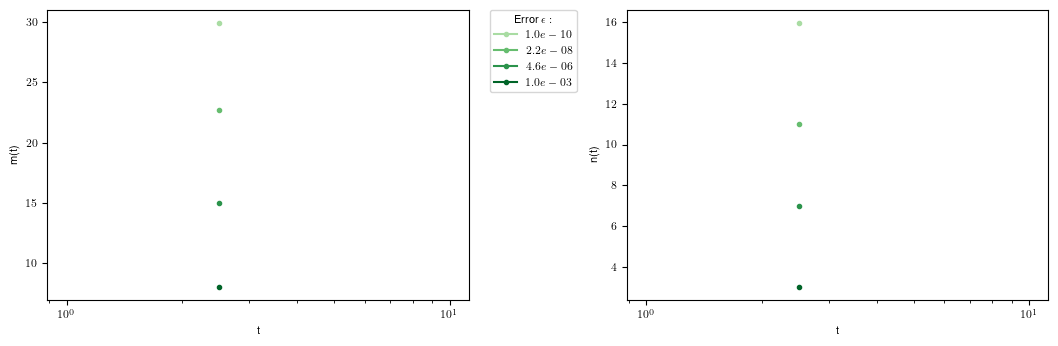

In [10]:
# Configuration and data preparation
error_grid = np.logspace(-10, -3, 4)
cmap_green = plt.get_cmap("Greens")
colors_green = cmap_green(np.linspace(0.35, 0.9, len(error_grid)))
fig, axs = plt.subplots(1, 2, figsize=(12.5, 3.5))

n_vals_interp = np.zeros((len(N_maxs), len(error_grid)))
m_vals_interp = np.zeros((len(N_maxs), len(error_grid)))

# Interpolation and plotting
for tau, t in enumerate(N_maxs):
    mask = errors[tau] > 1.e-12  # Mask to filter non-zero values
    N_VALS_INTERP = DataInterp(errors[tau, mask], n_vals[tau, mask])
    M_VALS_INTERP = DataInterp(errors[tau, mask], m_vals[tau, mask])

    n_vals_interp[tau, :] = N_VALS_INTERP.interp(error_grid, x_scale='log')
    m_vals_interp[tau, :] = M_VALS_INTERP.interp(error_grid, x_scale='log')

t_data = N_maxs * params["delta_t"]
for eps_iter, eps_val in enumerate(error_grid):
    label = f'${eps_val:.1e}$'  # Scientific notation for error values
    plot_data(axs[0], t_data[1:], m_vals_interp[1:, eps_iter], colors_green[eps_iter], label)
    plot_data(axs[1], t_data[1:], n_vals_interp[1:, eps_iter], colors_green[eps_iter], label)

# Setting labels and legend
axs[0].set_xlabel('t')
axs[0].set_ylabel('m(t)')
axs[1].set_xlabel('t')
axs[1].set_ylabel('n(t)')

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].legend(title='Error ' + r'$\epsilon:$', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to fit the legend

plt.savefig("../plots/modes_vs_time.pdf", bbox_inches='tight')
